In [ ]:
!pip install torch torchvision

Creating balanced datasets...
Selected 50 videos for Arson
Selected 50 videos for Explosion
Selected 50 videos for Fighting
Selected 50 videos for Stealing
Loading train dataset...


100%|██████████| 190/190 [10:11<00:00,  3.22s/it]


Finished loading train dataset... Loaded 19000 images.
Class distribution:
  Arson: 4800 frames
  Explosion: 4700 frames
  Fighting: 4700 frames
  Stealing: 4800 frames
Selected 50 videos for Arson
Selected 50 videos for Explosion
Selected 50 videos for Fighting
Selected 50 videos for Stealing
Loading test dataset...


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


Finished loading test dataset... Loaded 1000 images.
Class distribution:
  Arson: 200 frames
  Explosion: 300 frames
  Fighting: 300 frames
  Stealing: 200 frames
Displaying sample images from test dataset...


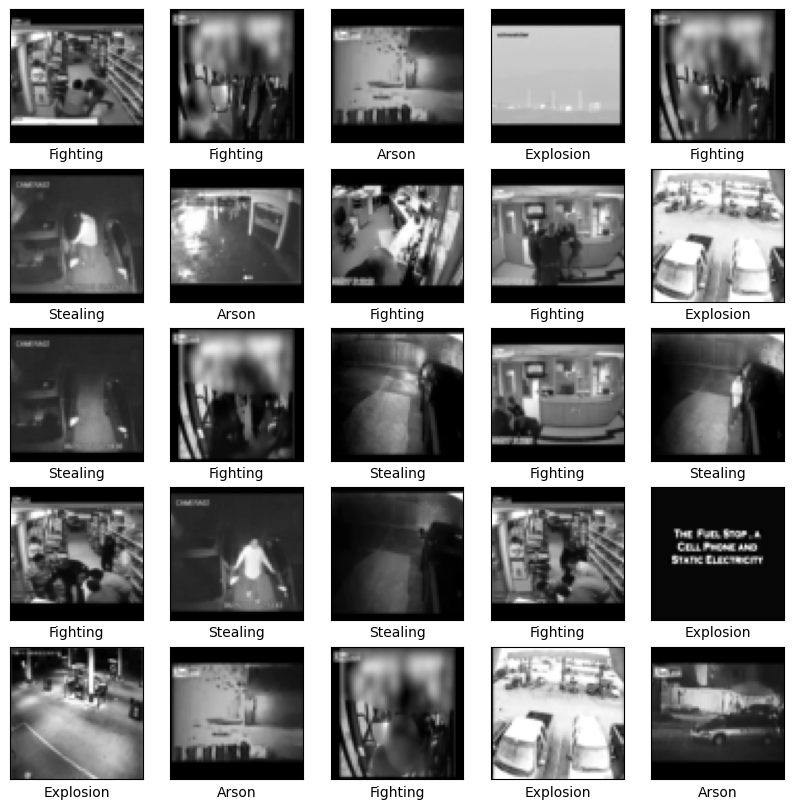

Initializing model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


Model will be trained with 4 classes
Training model...
Epoch 1/15...
Batch: [20/297], Loss: 0.4741
Batch: [40/297], Loss: 0.5115
Batch: [60/297], Loss: 0.2353
Batch: [80/297], Loss: 0.1749
Batch: [100/297], Loss: 0.1604
Batch: [120/297], Loss: 0.1114
Batch: [140/297], Loss: 0.1548
Batch: [160/297], Loss: 0.0421
Batch: [180/297], Loss: 0.1179
Batch: [200/297], Loss: 0.1908
Batch: [220/297], Loss: 0.1217
Batch: [240/297], Loss: 0.0793
Batch: [260/297], Loss: 0.0725
Batch: [280/297], Loss: 0.0754
Epoch 1 results:
  Train Loss: 0.2328, Train Accuracy: 92.08%
  Val Loss: 3.2008, Val Accuracy: 24.20%
  New best model saved! (Val Loss: 3.2008)
Epoch 2/15...
Batch: [20/297], Loss: 0.3109
Batch: [40/297], Loss: 0.0558
Batch: [60/297], Loss: 0.1223
Batch: [80/297], Loss: 0.0602
Batch: [100/297], Loss: 0.1060
Batch: [120/297], Loss: 0.0633
Batch: [140/297], Loss: 0.1136
Batch: [160/297], Loss: 0.0224
Batch: [180/297], Loss: 0.0234
Batch: [200/297], Loss: 0.0044
Batch: [220/297], Loss: 0.0107
Batc

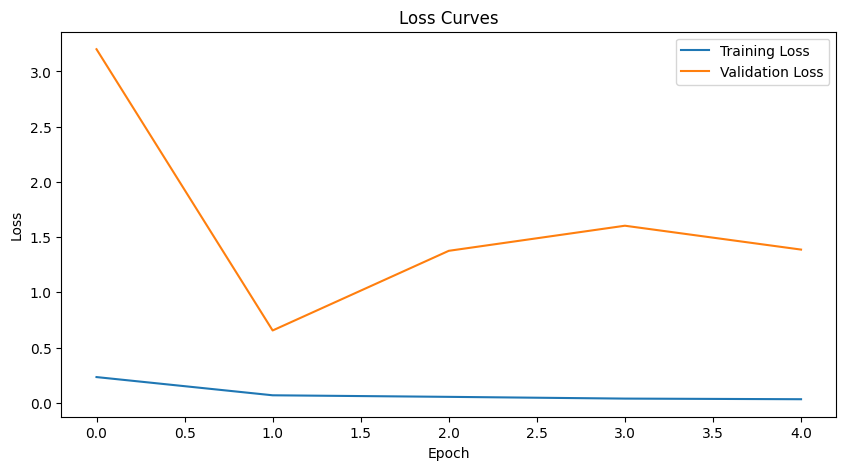

Model saved to balanced_resnet_crime_model.pt
Evaluating model...


100%|██████████| 16/16 [00:00<00:00, 22.51it/s]


Test Accuracy: 62.20%


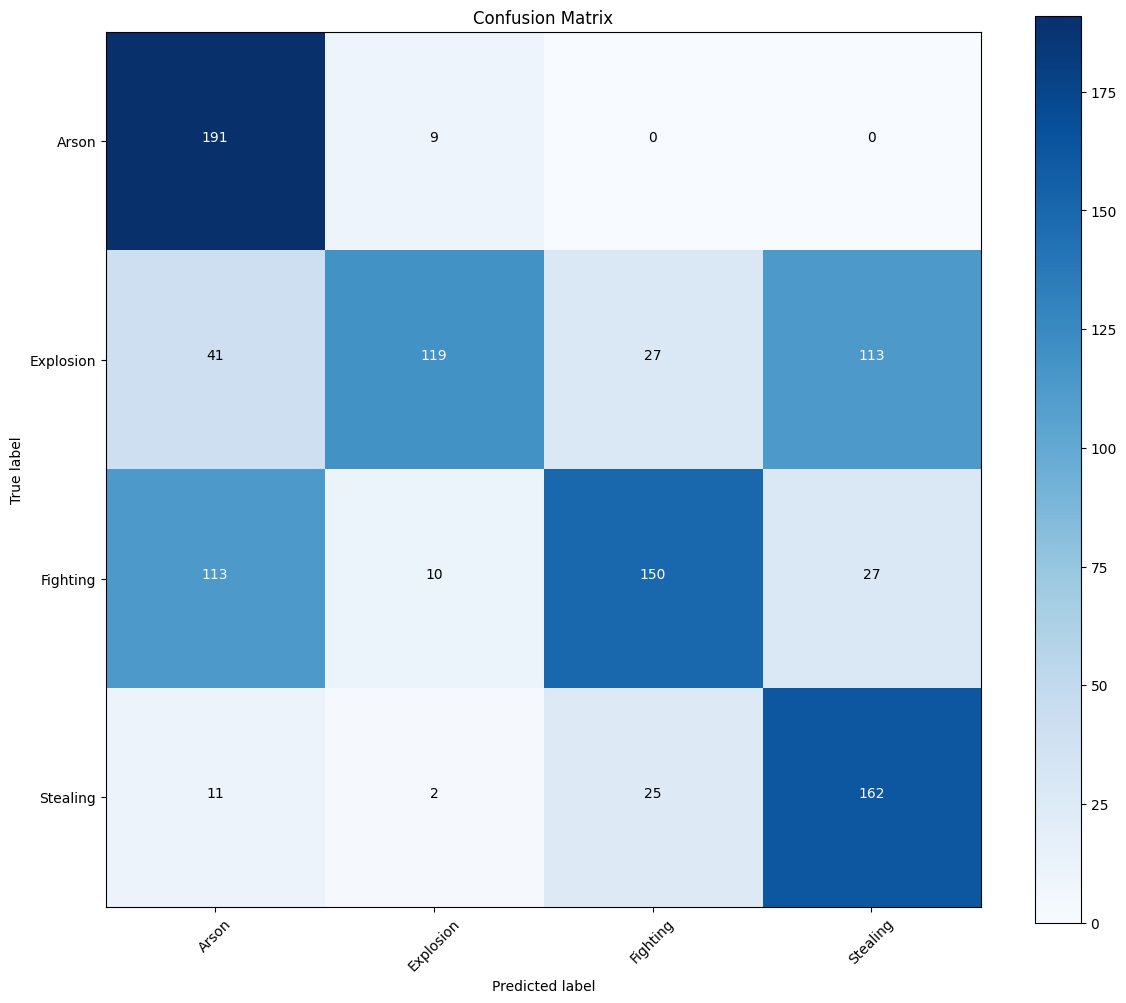


Per-class metrics:
Arson:
  Precision: 0.5365
  Recall: 0.9550
  F1 Score: 0.6871
Explosion:
  Precision: 0.8500
  Recall: 0.3967
  F1 Score: 0.5409
Fighting:
  Precision: 0.7426
  Recall: 0.5000
  F1 Score: 0.5976
Stealing:
  Precision: 0.5364
  Recall: 0.8100
  F1 Score: 0.6454
Displaying random predictions...


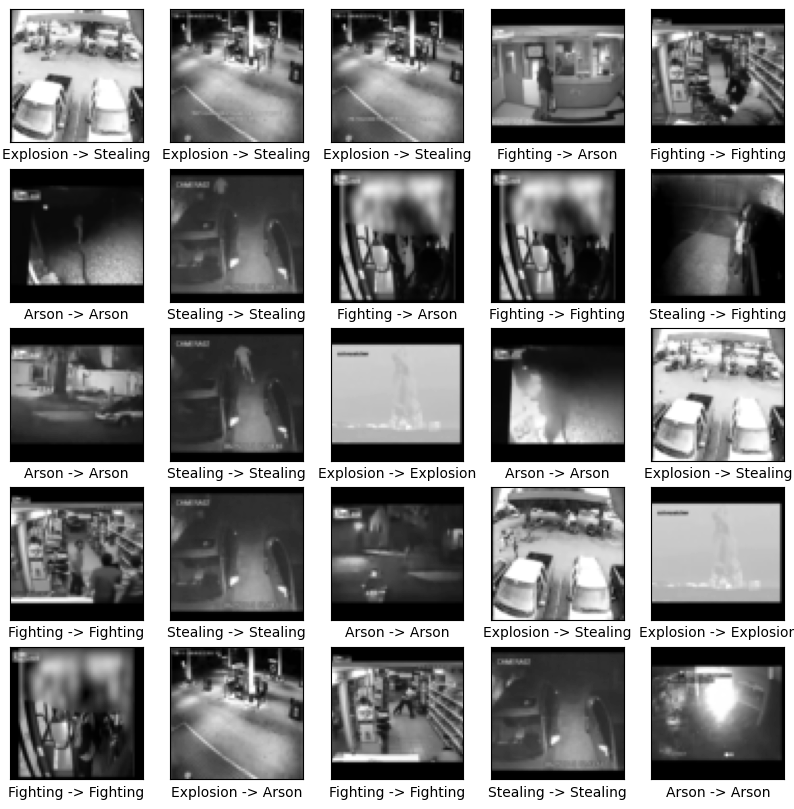

Done!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2
import random
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RESOLUTION = 64

# Dataset paths
DATA_SOURCE = {
    "Arson": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-1/Anomaly-Videos-Part-1/Arson",
    "Explosion": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part_2/Anomaly-Videos-Part-2/Explosion",
    "Fighting": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part_2/Anomaly-Videos-Part-2/Fighting",
    "Stealing": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-4/Anomaly-Videos-Part-4/Stealing",
}

# Function to select balanced videos
def select_balanced_videos(data_paths, videos_per_class=50, seed=42):
    random.seed(seed)
    balanced_paths = {}
    
    for label, path in data_paths.items():
        if os.path.exists(path):
            all_videos = [f for f in os.listdir(path) if f.endswith(".mp4")]
            
            # If we have more videos than needed, randomly select subset
            if len(all_videos) > videos_per_class:
                selected_videos = random.sample(all_videos, videos_per_class)
            else:
                selected_videos = all_videos
                
            # Store the full paths of selected videos
            balanced_paths[label] = [os.path.join(path, video) for video in selected_videos]
            
            print(f"Selected {len(selected_videos)} videos for {label}")
        else:
            print(f"Warning: Path {path} does not exist")
            balanced_paths[label] = []
            
    return balanced_paths

# Data transforms
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize((RESOLUTION, RESOLUTION), antialias=True)
])

# Balanced dataset class
class BalancedCrimeDataset(Dataset):
    def __init__(self, data_source, train=True, train_test_split=0.95, random_state=42, frames_per_video=60):
        torch.manual_seed(random_state)
        random.seed(random_state)
        
        self._data = []
        self._labels = []
        self._class_counts = {label: 0 for label in data_source.keys()}
        self._frames_per_video = frames_per_video
        
        # Get balanced video paths
        balanced_paths = select_balanced_videos(data_source, videos_per_class=50, seed=random_state)
        
        # Flatten the dictionary of paths
        all_video_paths = []
        for label, paths in balanced_paths.items():
            for path in paths:
                all_video_paths.append((path, label))
        
        # Shuffle all paths
        random.shuffle(all_video_paths)
        
        # Split into train and test
        split_idx = int(len(all_video_paths) * train_test_split)
        selected_paths = all_video_paths[:split_idx] if train else all_video_paths[split_idx:]
        
        print(f"Loading {'train' if train else 'test'} dataset...")
        for path, label in tqdm(selected_paths):
            data, labels = self._parse_file(path, label)
            self._data.extend(data)
            self._labels.extend(labels)
            self._class_counts[label] += len(data)
            
        print(f"Finished loading {'train' if train else 'test'} dataset... Loaded {len(self._data)} images.")
        print("Class distribution:")
        for label, count in sorted(self._class_counts.items()):
            print(f"  {label}: {count} frames")
        
    def _parse_file(self, path, label):
        if not os.path.exists(path):
            return [], []
        
        data = []
        labels = []
        
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames <= 0:
            print(f"Warning: Could not determine frame count for {path}")
            return [], []
        
        # Calculate sampling rate to get evenly distributed frames
        if total_frames <= self._frames_per_video:
            # If video is shorter than desired frames, take all frames
            frame_indices = list(range(total_frames))
        else:
            # Otherwise, sample evenly
            frame_indices = [int(i * total_frames / self._frames_per_video) for i in range(self._frames_per_video)]
        
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            success, image = cap.read()
            
            if success:
                try:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                    Y, U, V = cv2.split(image)
                    image = transformer(Y)
                    data.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing frame {frame_idx} from {path}: {e}")
        
        cap.release()
        return data, labels
    
    def label_str2id(self, label):
        labels = list(DATA_SOURCE.keys())
        return labels.index(label)
    
    def label_id2str(self, label_id):
        labels = list(DATA_SOURCE.keys())
        return labels[label_id]
    
    def __len__(self):
        return len(self._labels)
    
    def __getitem__(self, idx):
        data = self._data[idx]
        label = self._labels[idx]
        return data, torch.tensor([self.label_str2id(label)])

# Utility functions
def plot_image_from_list(__images, __labels, __count):
    plt.figure(figsize=(10, 10))
    for _i in range(__count[0] * __count[1]):
        plt.subplot(__count[0], __count[1], _i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        _img = __images[_i].to("cpu").numpy()
        plt.imshow(_img, cmap="gray")
        plt.xlabel(__labels[_i])
    plt.show()
    
def plot_randomly_form_dataset(__dataset):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        labels.append(__dataset.label_id2str(label.item()))
    
    plot_image_from_list(images, labels, (5, 5))
    
def plot_randomly_form_dataset_model(__dataset, __model):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        result = __model(image.unsqueeze(dim=0).to(device)).squeeze().cpu().argmax()
        
        labels.append(__dataset.label_id2str(label.item()) + " -> " + __dataset.label_id2str(result.item()))
    
    plot_image_from_list(images, labels, (5, 5))

# ResNet-based model
class CrimeModelResNet(nn.Module):
    def __init__(self):
        super(CrimeModelResNet, self).__init__()
        # Load pre-trained ResNet18
        resnet = models.resnet18(pretrained=True)
        
        # Modify the first conv layer to accept grayscale (1 channel) input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Copy weights from the pretrained model's first layer (average across channels)
        with torch.no_grad():
            self.conv1.weight = nn.Parameter(
                resnet.conv1.weight.sum(dim=1, keepdim=True)
            )
        
        # Use the rest of ResNet (except first conv and final fc)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        
        # Custom final layer
        self.fc = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.dropout(x)
        
        return x

# LSTM Model
class CrimeModelLSTM(nn.Module):
    def __init__(self):
        super(CrimeModelLSTM, self).__init__()
        self.lstm1 = nn.LSTM(1, 8, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(8, 8, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(8, 4)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)
        return x

# Combined Model
class CrimeModel(nn.Module):
    def __init__(self):
        super(CrimeModel, self).__init__()
        self.resnet = CrimeModelResNet()
        self.lstm = CrimeModelLSTM()
        self.fc = nn.Linear(260, len(DATA_SOURCE))
        
    def forward(self, x):
        x_resnet = x
        x_lstm = torch.reshape(x, (x.shape[0], RESOLUTION * RESOLUTION, 1))
        
        x_resnet = self.resnet(x_resnet)
        x_lstm = self.lstm(x_lstm)
        
        x_combined = torch.cat((x_resnet, x_lstm), dim=1)
        x = self.fc(x_combined)
        
        return x

# Training function with early stopping
def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, patience=3):
    model = nn.DataParallel(model)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        print(f"Epoch {epoch+1}/{num_epochs}...")
        
        for batch_idx, (data, label) in enumerate(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, label.squeeze())
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += label.size(0)
            correct_train += (predicted == label.squeeze()).sum().item()
            
            # Print batch progress
            if (batch_idx + 1) % 20 == 0:
                print(f"Batch: [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                outputs = model(data)
                loss = criterion(outputs, label.squeeze())
                
                total_val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += label.size(0)
                correct_val += (predicted == label.squeeze()).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1} results:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model
            best_model = model.module.state_dict()
            print(f"  New best model saved! (Val Loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load the best model
    if best_model is not None:
        model.module.load_state_dict(best_model)
    
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model

# Function to evaluate model and generate confusion matrix
def evaluate_model(model, test_loader, dataset):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, label in tqdm(test_loader):
            data = data.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.squeeze().cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Generate confusion matrix
    class_names = list(DATA_SOURCE.keys())
    cm = np.zeros((len(class_names), len(class_names)), dtype=int)
    
    for true_label, pred_label in zip(all_labels, all_preds):
        cm[true_label][pred_label] += 1
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Calculate per-class metrics
    precision = {}
    recall = {}
    f1_score = {}
    
    for i, class_name in enumerate(class_names):
        # Precision: TP / (TP + FP)
        precision[class_name] = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
        
        # Recall: TP / (TP + FN)
        recall[class_name] = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        
        # F1 Score: 2 * (precision * recall) / (precision + recall)
        if precision[class_name] + recall[class_name] > 0:
            f1_score[class_name] = 2 * (precision[class_name] * recall[class_name]) / (precision[class_name] + recall[class_name])
        else:
            f1_score[class_name] = 0
    
    # Print metrics
    print("\nPer-class metrics:")
    for class_name in class_names:
        print(f"{class_name}:")
        print(f"  Precision: {precision[class_name]:.4f}")
        print(f"  Recall: {recall[class_name]:.4f}")
        print(f"  F1 Score: {f1_score[class_name]:.4f}")
    
    return all_preds, all_labels, cm

# Main execution
def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Create balanced datasets
    print("Creating balanced datasets...")
    train_dataset = BalancedCrimeDataset(DATA_SOURCE, train=True, frames_per_video=100)
    test_dataset = BalancedCrimeDataset(DATA_SOURCE, train=False, frames_per_video=100)
    
    # Display sample images
    print("Displaying sample images from test dataset...")
    plot_randomly_form_dataset(test_dataset)
    
    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Initialize the model
    print("Initializing model...")
    model = CrimeModel()
    print(f"Model will be trained with {len(DATA_SOURCE)} classes")
    
    # Train the model
    print("Training model...")
    model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,
        num_epochs=15,
        lr=0.001,
        patience=3
    )
    
    # Save the trained model
    torch.save(model.module.state_dict(), "balanced_resnet_crime_model.pt")
    print("Model saved to balanced_resnet_crime_model.pt")
    
    # Evaluate the model
    print("Evaluating model...")
    predictions, true_labels, confusion_matrix = evaluate_model(model, test_loader, test_dataset)
    
    # Display predictions
    print("Displaying random predictions...")
    plot_randomly_form_dataset_model(test_dataset, model)
    
    print("Done!")

if __name__ == "__main__":
    main()